In [1]:
!wget https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json

--2023-01-10 02:05:22--  https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘sarcasm.json’

sarcasm.json        100%[===================>]   5.38M  19.6MB/s    in 0.3s    

2023-01-10 02:05:23 (19.6 MB/s) - ‘sarcasm.json’ saved [5643545/5643545]



In [2]:
import json

with open("./sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [3]:
training_size = 20000
vocab_size = 10000
max_length = 32
embedding_dim = 16

In [4]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [5]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [6]:
import tensorflow as tf

gap1d_layer = tf.keras.layers.GlobalAveragePooling1D()

sample_array = np.array([[[10,2],[1,3],[1,1]]])

print(f'shape of sample_array = {sample_array.shape}')
print(f'sample array: {sample_array}')

output = gap1d_layer(sample_array)

print(f'output shape of gap1d_layer: {output.shape}')
print(f'output array of gap1d_layer: {output.numpy()}')

shape of sample_array = (1, 3, 2)
sample array: [[[10  2]
  [ 1  3]
  [ 1  1]]]
output shape of gap1d_layer: (1, 2)
output array of gap1d_layer: [[4 2]]


In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 16)            160000    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [9]:
num_epochs = 30

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 2s - loss: 0.5452 - accuracy: 0.7185 - val_loss: 0.3886 - val_accuracy: 0.8411 - 2s/epoch - 4ms/step
Epoch 2/30
625/625 - 1s - loss: 0.3062 - accuracy: 0.8783 - val_loss: 0.3415 - val_accuracy: 0.8565 - 1s/epoch - 2ms/step
Epoch 3/30
625/625 - 2s - loss: 0.2300 - accuracy: 0.9108 - val_loss: 0.3434 - val_accuracy: 0.8532 - 2s/epoch - 3ms/step
Epoch 4/30
625/625 - 2s - loss: 0.1851 - accuracy: 0.9305 - val_loss: 0.3712 - val_accuracy: 0.8504 - 2s/epoch - 4ms/step
Epoch 5/30
625/625 - 3s - loss: 0.1543 - accuracy: 0.9431 - val_loss: 0.3929 - val_accuracy: 0.8481 - 3s/epoch - 4ms/step
Epoch 6/30
625/625 - 3s - loss: 0.1311 - accuracy: 0.9528 - val_loss: 0.4280 - val_accuracy: 0.8457 - 3s/epoch - 4ms/step
Epoch 7/30
625/625 - 3s - loss: 0.1113 - accuracy: 0.9621 - val_loss: 0.4704 - val_accuracy: 0.8395 - 3s/epoch - 5ms/step
Epoch 8/30
625/625 - 2s - loss: 0.0956 - accuracy: 0.9683 - val_loss: 0.5167 - val_accuracy: 0.8353 - 2s/epoch - 3ms/step
Epoch 9/30
625/625 - 2s 

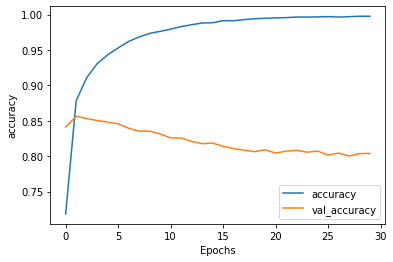

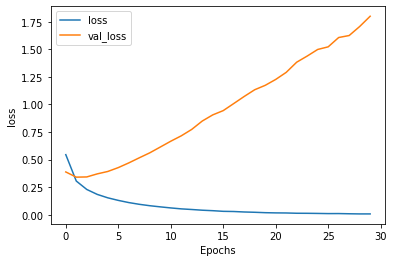

In [10]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [11]:
reverse_word_index = tokenizer.index_word
embedding_layer = model.layers[0]
embedding_weights = embedding_layer.get_weights()[0]

print(embedding_weights.shape) 

(10000, 16)


In [12]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for word_num in range(1, vocab_size):
  word_name = reverse_word_index[word_num]
  word_embedding = embedding_weights[word_num]
  out_m.write(word_name + "\n")
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

out_v.close()
out_m.close()

In [13]:
try:
  from google.colab import files
except ImportError:
  pass

else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[Embedding Projector](https://projector.tensorflow.org/)